# Polarization with GYOTO
***

## This notebook has been created as an example of how to compute and use polarization with *GYOTO* in python.

**For this exemple, we will consider a thick disk emitting thermal synchrotron radiation around a Schwarzschild black hole.** The setup that we consider here is similar of [Vos et al. (2023)](https://ui.adsabs.harvard.edu/abs/2022A%26A...668A.185V/abstract) and implemented in [Aimar et al. (2023)]() for comparing *Gyoto* and *ipole* computation.

*Gyoto* will compute images for the four Stokes parameters that describe the polarisation of light. From these images, we can then compute the *Electric Vector Position Angle* (EVPA) that we can represent with ticks (see below).

## **1 - Importing libraries**

In [ ]:
import gyoto
import gyoto.std
import gyoto.core
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## **2 - Defining usefull constants**

In [ ]:
kpc_meter=3.08568025e19
c_SI=299792458.
me_SI=9.10938188e-28
kb_SI=1.3806504e-23

## **3 - Create a *Gyoto* Scenery**

### **3.1 - Defining the metric**

**The first thing to do is defining our metric**. We consider a Schwarzschild black hole which can be described by the Kerr metric with a null spin ($a=0$). We can take the *Boyer-Lindquiest* (metric **KerrBL**) or the *Kerr-Schild* (metric **KerrKS**) coordinate system. It does not change anything for this exemple.

We take the approximate mass of Sagittarius A* (around 4.3 millions solar masses) in this exemple to use classical units. However, everything can be expressed in geometrical units (see next section). In that case, the mass is not mandatory.

In [ ]:
metric = gyoto.std.KerrBL()
metric.spin(0.)
metric.mass(4.3e6,"sunmass")

### **3.2 - Defining the observer's screen**

**We then need to define the observer's screen.**

The screen need few parameters to be properly defined. The first of interest is its 4-position which can be set by the means of two angles : **inclination** (polar angle), called hereafter *incli* and **argument** (azimuthal angle; default value here). In addition to the two previous angle we need to define the **distance**, herefater *dist* and launch **time** of the photons from the screen. 
Another possibility to define the screen's 4-position is by 3D vector **Position** and **Time**. For this exemple we show the first option.

After the position, we need to define the properties of the screen like the Field of View (*fov*), the number of pixel along both axes *npix* and the observed frequency(ies). Here we set only one observed frequency at $230$ GHz (like the EHT).

One last angle is needed to finish the definition of the screen, the Position Angle of the Line of Nodes (PALN). A PALN of 180° correspond to a spin axis aligned with the vertical axis of the screen (toward the top).

To summurize, the screen needs the following parameters to e setup :
- **Distance**
- **Time** (should correspond approximatively to distance so that photons coordinate time is close to zero when arriving close to the black hole)
- **Inclination**
- **Field of View**
- **Resolution** (number of pixels on ech axes)
- **Observed frequency**

Note that **Distance**, **Field of View** and **Time** can be expressed in geometrical units with the string *"geometrical"* for the first two and *"geometrical_time"* for **Time**.

In [ ]:
incli = 20 # deg
dist = 8.3 # kpc
fov = 200 # muas
npix = 1024
nu = 230e9 # Hz

screen = gyoto.Screen()
screen.metric(metric) # first step : give the metric to the screen
screen.distance(dist,"kpc")
screen.time(dist,"kpc")
screen.fieldOfView(fov,"µas")
screen.inclination(180.-incli,"°")
screen.PALN(180,"°")
screen.resolution(npix)
spectro=gyoto.core.Spectrometer('freqlog')
spectro.set("NSamples", 1)
spectro.set("Band", (math.log10(nu), math.log10(nu)), "Hz")
screen.spectrometer(spectro)

### **3.3 - Defining the emitting astrophysical object**

The last object that to be defined is the emitting region. Here, we consider a thick disk, emitting synchrotron radiation from a thermal distribution of electrons. The *Thick disk* is characterised by its geometry (**thickness**, **inner** and **outer radii**) as the profiles of physical quantities like **number density**, **temperature** and **magnetic field**. For polarisation, the **magnetic field configuration** is of great interest and needs to be specified.

As said before, we use the ipole formalism for this exemple, see [Vos et al. (2023)](https://ui.adsabs.harvard.edu/abs/2022A%26A...668A.185V/abstract) and [Aimar et al. (2023)]() for more details.

*Note : the fitting formulae for the synchrotron coefficients are the ones from [Marszewski et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...921...17M/abstract)*

In [ ]:
disk = gyoto.std.ThickDisk()
disk.thickDiskInnerRadius(6.)
disk.thickDiskZGaussianSigma(0.3)
disk.numberDensityAtInnerRadius(6e6,"cm-3")
disk.temperatureAtInnerRadius(200.*me_SI*c_SI*c_SI/kb_SI)
disk.temperatureSlope(-0.84)
disk.densitySlope(-1.5)
disk.metric(metric)
disk.opticallyThin(True)
disk.magneticConfiguration('Vertical')
disk.rMax(100) # stop condition of geodesic integration
disk.deltaInObj(0.05) # integraton step for radiative transfer

### **3.4 - Generating the *Gyoto* scenery**

Now that we have defined all our objects (**metric**, **screen**, **astrobj**), we can create and set the complete **scenery**.

<font color='red'> An important difference with non polarized radiative transfer is the need of **parallel transport**. This flag **MUST** be put to True to compute polarized quantities.

We also define here the quantities that we want to compute. In the exemple below we ask the four Stokes parameters.     

*Note : The parallel transport flag will enable all the polarized stuffs in the code and prioritize the polarized radiative transfer functions which might differ from the non-polarized versions. Thus, it is recommanded to let this flag to False for non polarized computations.*
    
*Note 2 : The computation of the EVPA requires a better integration accuracy of the geodesics than the non polarized quantities. In such cases, one can reduce the **relative** and/or **absolute tolerance value(s)** (relTol and absTol respectively) or the parameter **DeltaMaxOverR**.*

In [ ]:
scry = gyoto.Scenery()
scry.metric(metric)
scry.screen(screen)
scry.astrobj(disk)
scry.tMin(-1e10) # stop condition of geodesic integration
scry.nThreads(8)
scry.parallelTransport(True)
scry.relTol(1.e-10)
scry.absTol(1.e-10)
#scry.deltaMaxOverR(0.1)

scry.requestedQuantitiesString("Spectrum SpectrumStokesQ SpectrumStokesU SpectrumStokesV")

## **4 - Generate polarized images**

It is now the time to perform the ray-tracing of the requested quantities and retrieve the produced images. Here the maps are converted from intensity in *SI* to flux in *Jansky*.

**Note : this step is be quite long with such high resolution**

In [ ]:
image_cube=scry.rayTrace()

SI2Jy = (fov*1e-6/3600*np.pi/180./npix)**2*1e26

imgI=image_cube["Spectrum"][0,:,:]*SI2Jy

imgQ=image_cube["SpectrumStokesQ"][0,:,:]*SI2Jy

imgU=image_cube["SpectrumStokesU"][0,:,:]*SI2Jy

imgV=image_cube["SpectrumStokesV"][0,:,:]*SI2Jy

***
## **5 - Plotting polarized images**

After generating the images in the four Stokes parameters, we can do... whatever we want !

The two following cells allow to plot the four Stokes images in a single figure with relevant colorbars : one for total intensity (Stokes I), one for linear polarization (Stokes Q and U) and one for circular polarization (Stokes V).

In [11]:
vmin = min(imgQ.min(), imgU.min())
vmax = max(imgQ.max(), imgU.max())
scale_LP = max(abs(vmin), abs(vmax))
normLP = colors.Normalize(vmin=-scale_LP, vmax=scale_LP)

scale_CP = max(abs(imgV.min()), abs(imgV.max()))
normCP = colors.Normalize(vmin=-scale_CP, vmax=scale_CP)

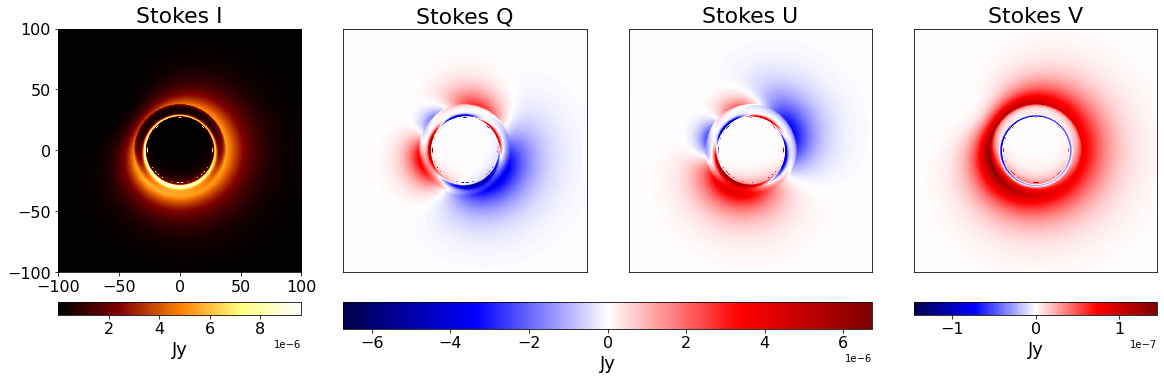

In [12]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(16, 9)
fig.tight_layout()


axs[0].tick_params(axis='both', which='major', labelsize=16)
for ii in range(1,4):
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])

cmap1 = 'afmhot'
cmap2 = "seismic"

img_Gyoto_I = axs[0].imshow(imgI, interpolation='nearest', origin='lower', cmap=cmap1, extent=(-fov/2.,fov/2.,-fov/2.,fov/2.))
axs[0].set_title("Stokes I", fontsize=22)
img_Gyoto_Q = axs[1].imshow(imgQ, interpolation='nearest', origin='lower', cmap=cmap2, norm=normLP, extent=(-fov/2.,fov/2.,-fov/2.,fov/2.))
axs[1].set_title("Stokes Q", fontsize=22)
img_Gyoto_U = axs[2].imshow(imgU, interpolation='nearest', origin='lower', cmap=cmap2, norm=normLP, extent=(-fov/2.,fov/2.,-fov/2.,fov/2.))
axs[2].set_title("Stokes U", fontsize=22)
img_Gyoto_V = axs[3].imshow(imgV, interpolation='nearest', origin='lower', cmap=cmap2, norm=normCP, extent=(-fov/2.,fov/2.,-fov/2.,fov/2.))
axs[3].set_title("Stokes V", fontsize=22)

cb_imgI = fig.colorbar(img_Gyoto_I, ax=axs[0], location='bottom', pad=0.05)
cb_imgI.set_label('Jy', fontsize=18)
cb_imgI.ax.tick_params(axis='both', which='major', labelsize=16)
cb_imgLP = fig.colorbar(img_Gyoto_Q, ax=axs[1:3], location='bottom', pad=0.05)
cb_imgLP.set_label('Jy', fontsize=18)
cb_imgLP.ax.tick_params(axis='both', which='major', labelsize=16)
cb_imgCP = fig.colorbar(img_Gyoto_V, ax=axs[3], location='bottom', pad=0.05)
cb_imgCP.set_label('Jy', fontsize=18)
cb_imgCP.ax.tick_params(axis='both', which='major', labelsize=16)

In this cell we plot the unpolarized images in background of the orientation of the EVPA for some pixels in the images represented by white ticks. The length of the ticks represent the local linear polarization fraction.

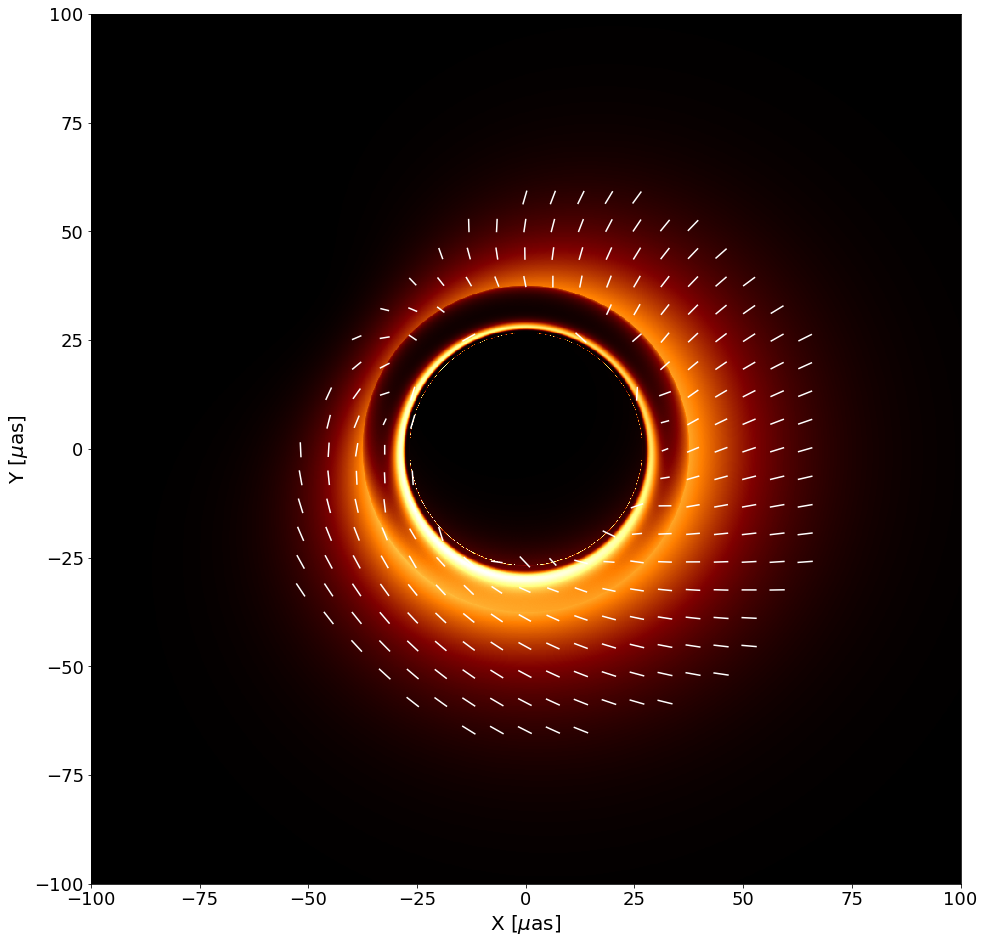

In [13]:
plt.figure(2, figsize=(16.,16.))
plt.clf()
plt.ion()
plt.gca().invert_xaxis()
plt.xlabel("X [$\mu$as]", fontsize=20.)
plt.ylabel("Y [$\mu$as]", fontsize=20.)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

imgEVPA=np.arctan2(imgU, imgQ)/2.
imgLP=np.sqrt(imgQ**2 +imgU**2)/imgI
imgCP = imgV/imgI

muasperpxl=fov/npix
ntick=31 # nb of ticks to plot along horiz dir
steps=int(npix/ntick)
multmarker=2. # size of polar arrow in plot
for itick in range(ntick):
    for jtick in range(ntick):
        imid=int(steps*itick+steps/2.)
        jmid=int(steps*jtick+steps/2.)
        Iloc=imgI[jmid,imid]
        EVPAloc=imgEVPA[jmid,imid]
        LPloc=imgLP[jmid,imid]
        xx=(imid-int(npix/2.))*muasperpxl
        yy=(jmid-int(npix/2.))*muasperpxl
        if imgI[jmid,imid]>0.08*imgI.max():
            plt.plot([xx+multmarker*LPloc*math.sin(EVPAloc),xx-multmarker*LPloc*math.sin(EVPAloc)],
                     [yy-multmarker*LPloc*math.cos(EVPAloc),yy+multmarker*LPloc*math.cos(EVPAloc)],
                     color='white', linewidth=1.5)

plt.imshow(imgI, interpolation='nearest', origin='lower', cmap=cmap1, extent=(-fov/2.,fov/2.,-fov/2.,fov/2.))